## Financial News Database EDA


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
from tqdm import tqdm
import chromadb
from chromadb.config import Settings
from chromadb.utils import embedding_functions

In [2]:
# Initialize ChromaDB client
client = chromadb.PersistentClient(
    path="./chromadb_storage",
    settings=Settings(),
)

# Get collection with same embedding function
hf_embedder = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

collection = client.get_collection(
    name="financial_news",
    embedding_function=hf_embedder
)


In [3]:
def safe_get_data(collection):
    """Retrieve data with error handling"""
    try:
        return collection.get(
            include=["documents", "metadatas"],
            limit=10000  # Adjust based on your dataset size
        )
    except Exception as e:
        print(f"Error retrieving data: {str(e)}")
        return {'ids': [], 'documents': [], 'metadatas': []}

all_data = safe_get_data(collection)

In [4]:
valid_records = []
for idx, doc_id in enumerate(all_data['ids']):
    try:
        record = {
            'id': doc_id,
            'content': all_data['documents'][idx],
            'ticker': all_data['metadatas'][idx].get('ticker', 'Unknown'),
            'timestamp': all_data['metadatas'][idx].get('providerPublishTime', 0),
            'url': all_data['metadatas'][idx].get('url', '')
        }
        valid_records.append(record)
    except Exception as e:
        print(f"Error processing record {doc_id}: {str(e)}")

In [5]:
df = pd.DataFrame(valid_records)
# Convert timestamp to datetime
df['publish_date'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
df['content_length'] = df['content'].str.len()

In [6]:
print("Dataset Overview:")
print(f"Total entries: {len(df)}")
print(f"Date range: {df['publish_date'].min()} to {df['publish_date'].max()}")
print(f"Unique tickers: {df['ticker'].nunique()}")

Dataset Overview:
Total entries: 720
Date range: 2024-04-22 16:00:00 to 2025-04-21 02:15:00
Unique tickers: 47


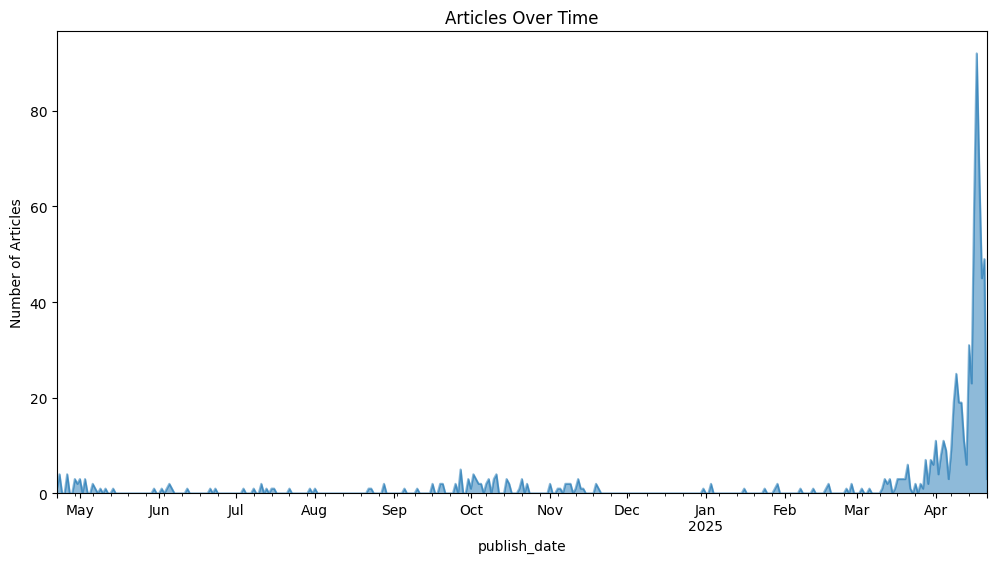

In [7]:
plt.figure(figsize=(12, 6))
df.resample('D', on='publish_date').size().plot(
    title='Articles Over Time',
    kind='area',
    alpha=0.5
)
plt.ylabel('Number of Articles')
plt.show()


/tmp/ipykernel_81593/2827342075.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticker_dist.values, y=ticker_dist.index, palette='viridis')


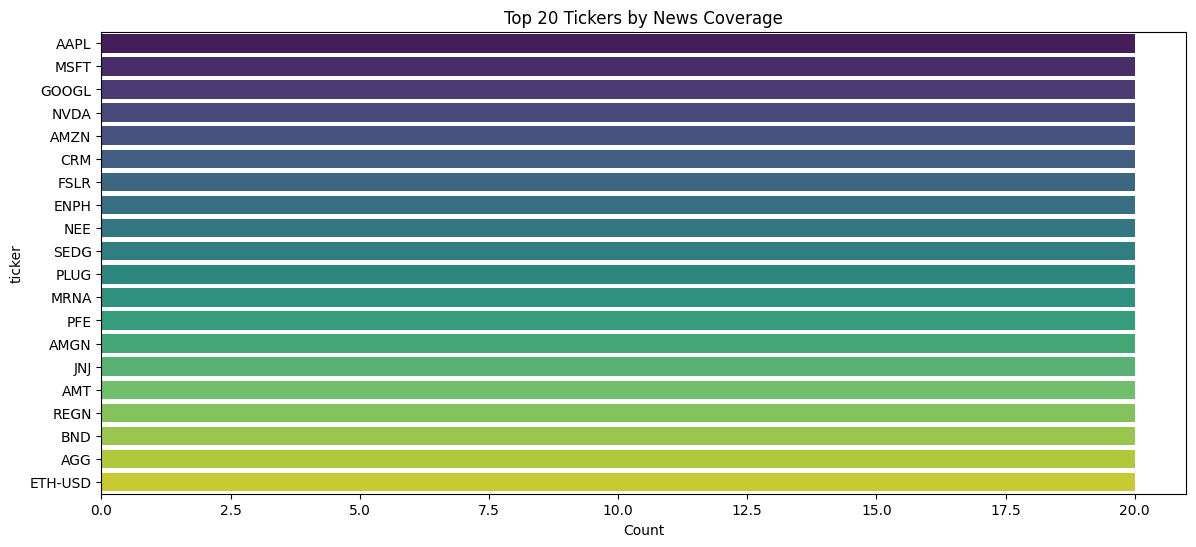

In [8]:
plt.figure(figsize=(14, 6))
ticker_dist = df['ticker'].value_counts().head(20)
sns.barplot(x=ticker_dist.values, y=ticker_dist.index, palette='viridis')
plt.title('Top 20 Tickers by News Coverage')
plt.xlabel('Count')
plt.show()

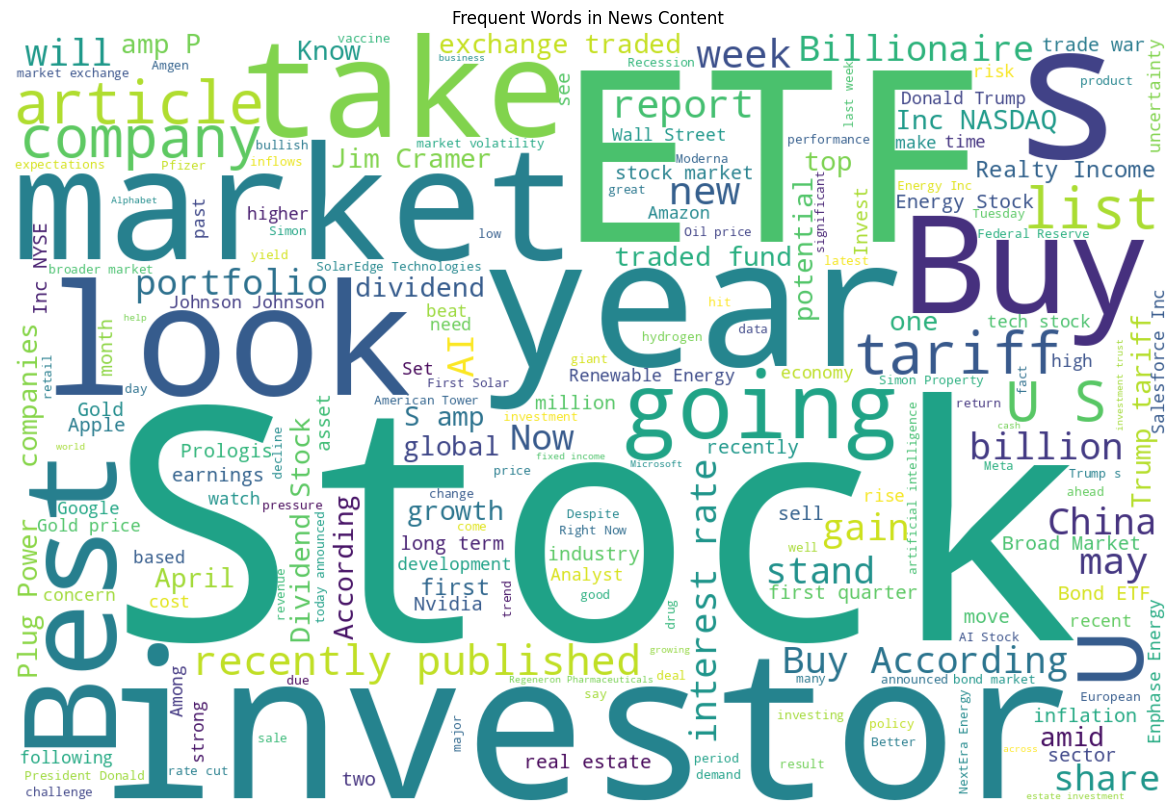

In [9]:
text = ' '.join(df['content'].dropna())
wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(text)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words in News Content')
plt.show()

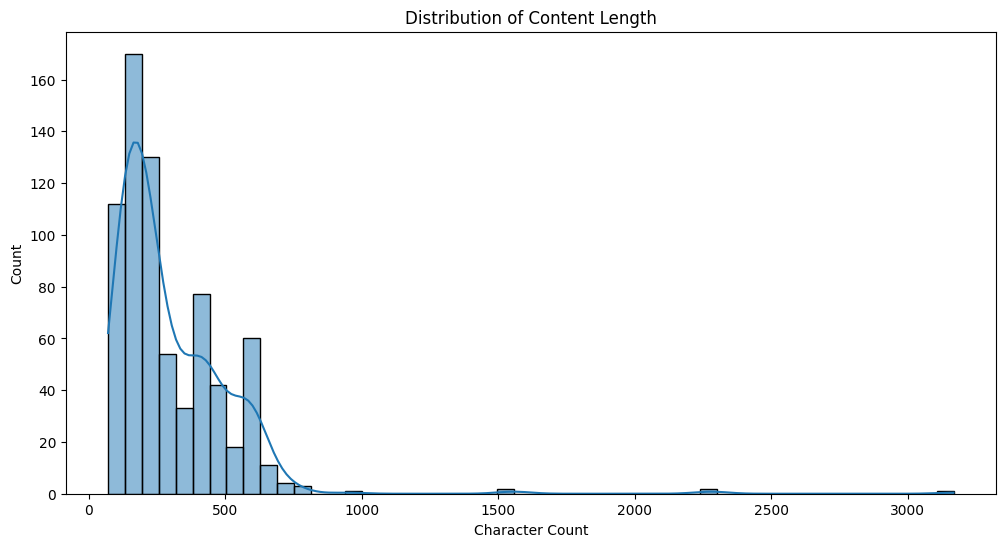

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(df['content_length'], bins=50, kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Character Count')
plt.show()


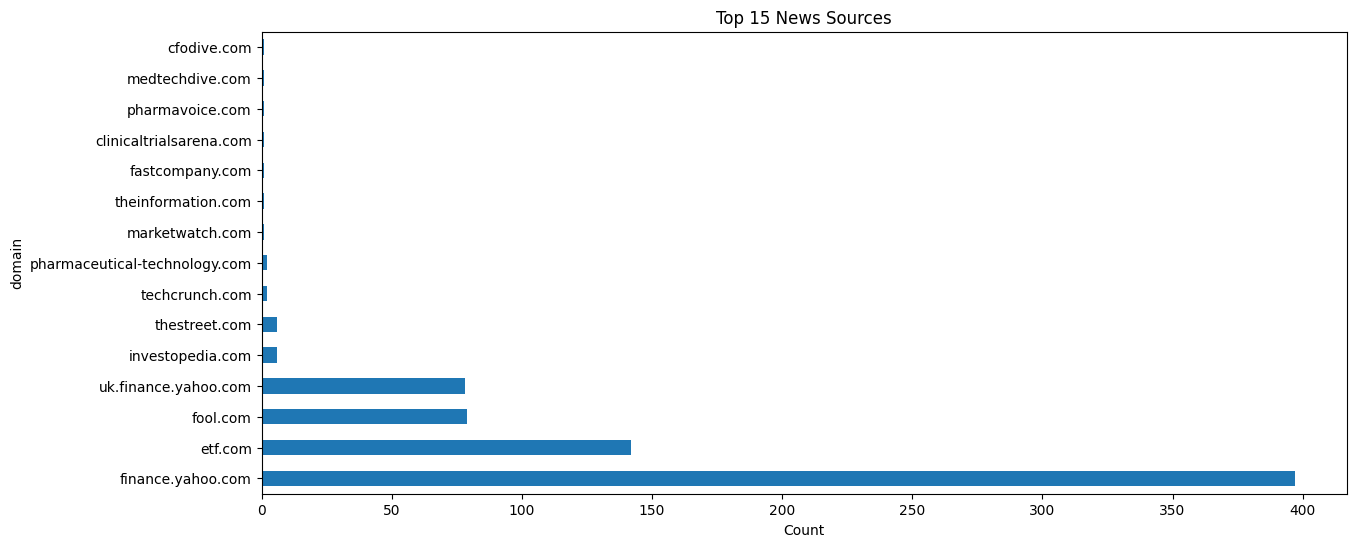

In [11]:
# Extract domains from URLs
df['domain'] = df['url'].str.extract(r'https?://(?:www\.)?([^/]+)')

plt.figure(figsize=(14, 6))
df['domain'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 News Sources')
plt.xlabel('Count')
plt.show()

In [12]:
sample_ids = df.sample(10)['id'].tolist()
try:
    embeddings = collection.get(ids=sample_ids, include=["embeddings"])['embeddings']
    print(f"Embedding dimensions: {len(embeddings[0])}")
    # Add PCA visualization here if needed
except KeyError:
    print("Embeddings not available - check ingestion configuration")
except Exception as e:
    print(f"Error retrieving embeddings: {str(e)}")

Embedding dimensions: 768


In [14]:
# %% [markdown]
# ## Duplicate News Analysis

# %%
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load the data
client = chromadb.PersistentClient(path="./chromadb_storage")
collection = client.get_collection("financial_news")

# Get all documents with metadata
all_data = collection.get(include=["documents", "metadatas", "embeddings"])

# Create DataFrame
df = pd.DataFrame({
    'id': all_data['ids'],
    'content': all_data['documents'],
    'ticker': [m.get('ticker') for m in all_data['metadatas']],
    'timestamp': [m.get('providerPublishTime') for m in all_data['metadatas']],
    'embedding': all_data['embeddings']
})

# %% [markdown]
# ### 1. Exact Duplicates Check

# %%
# Check for identical content
content_dupes = df[df.duplicated(subset=['content'], keep=False)]
print(f"Found {len(content_dupes)} potential exact duplicates")
if not content_dupes.empty:
    display(content_dupes.sample(3)[['ticker', 'content', 'timestamp']])

# %% [markdown]
# ### 2. ID-Based Duplicates

# %%
# Check for duplicate IDs (should never happen with your hash-based IDs)
id_dupes = df[df.duplicated(subset=['id'], keep=False)]
print(f"Found {len(id_dupes)} ID duplicates (critical issue if >0)")
if not id_dupes.empty:
    display(id_dupes)

# %% [markdown]
# ### 3. Semantic Similarity Check

# %%
def find_semantic_duplicates(threshold=0.95, samples=1000):
    """Find similar articles using embedding cosine similarity"""
    # Use a subset for performance
    sample_df = df.sample(min(samples, len(df)))
    embeddings = np.array(sample_df['embedding'].tolist())
    
    # Calculate pairwise similarities
    similarities = cosine_similarity(embeddings)
    
    # Find high similarity pairs (excluding self-comparisons)
    duplicates = []
    for i in tqdm(range(len(similarities))):
        for j in range(i+1, len(similarities)):
            if similarities[i][j] > threshold:
                duplicates.append((
                    sample_df.iloc[i]['id'],
                    sample_df.iloc[j]['id'],
                    similarities[i][j]
                ))
    
    return pd.DataFrame(duplicates, columns=['id1', 'id2', 'similarity'])

# Find duplicates with 95% similarity threshold
semantic_dupes = find_semantic_duplicates()
print(f"Found {len(semantic_dupes)} potential semantic duplicates")
if not semantic_dupes.empty:
    # Show most similar examples
    display(semantic_dupes.sort_values('similarity', ascending=False).head(5))

# %% [markdown]
# ### 4. Source-Based Duplicates

# %%
# Check for same URL across different tickers
url_dupes = df[df.duplicated(subset=['url'], keep=False)]
print(f"Found {len(url_dupes)} URL-based duplicates")
if not url_dupes.empty:
    display(url_dupes.groupby('url')['ticker'].unique().head(10))

# %% [markdown]
# ### 5. Temporal Duplicates

# %%
# Check for same content within short time window
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
time_dupes = df.sort_values('datetime').groupby('ticker').apply(
    lambda x: x[x['content'].shift() == x['content']]
).reset_index(level=0, drop=True)

print(f"Found {time_dupes.sum()} temporal duplicates")
if time_dupes.any():
    display(df[time_dupes].sample(3)[['ticker', 'content', 'datetime']])

# %% [markdown]
# ## Duplicate Removal

# %%
def remove_duplicates(collection, strategy='exact'):
    """Remove duplicates based on selected strategy"""
    if strategy == 'exact':
        # Remove exact content duplicates
        dupes = df[df.duplicated(subset=['content'])]['id'].tolist()
    elif strategy == 'semantic':
        # Remove semantic duplicates (keep first occurrence)
        all_dupes = semantic_dupes['id2'].tolist()
        dupes = list(set(all_dupes))
    elif strategy == 'url':
        # Remove URL duplicates across tickers
        dupes = df[df.duplicated(subset=['url'])]['id'].tolist()
    
    logger.info(f"Removing {len(dupes)} duplicates using {strategy} strategy")
    collection.delete(ids=dupes)
    
# Example usage (uncomment to run)
# remove_duplicates(collection, strategy='exact')

ValueError: Per-column arrays must each be 1-dimensional